## Problem definition: Classification of PET images into healthy and AD.


In this jupyter notebook, you will learn to classify PET images into health/congitively normal (CN) and Alzheimer's disease (AD) by using transfer learning using a pre-trained network. 

## You will learn 2 ways of customizing a pre-trained network:
1. Feature extraction: Use the representations learnt by the pre-trained model to extract features from the new images. You just add a classifer layer which will be trained from scratch on top of the pretrained model. You do not need to retrain the entire model.
2. Fine-tuning: Unfreeze few top layers of the frozen model and jointly train with the newly added classifier layer and the last layers of the base modelThie allows us to "fine-tune" the higher order representations in the base model to make it more suitable for the task in hand. .  


## Objectivies (What will we learn here?)

1. Setting up the env
2. Create training, validation and test ids
3. Image pre-processing
4. Image augmentation
5. Building the classification model
6. Feature extraction
7. Looking at learning curves
8. Fine-tuning
9. Looking at the learning curves
10. Predicting using the build model
11. What next? It is time to play!

## Step 1: Set up the env

In [1]:
import os
import numpy as np
from numpy import expand_dims
import cv2
import nibabel as nib 
import matplotlib.pyplot as plt
import glob
import pandas as pd
from pathlib import Path
from google.colab import drive
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
from keras import layers
import keras.backend as K
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization, Dropout
from tensorflow.keras.layers.experimental import preprocessing 
from tensorflow.keras.optimizers import *
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
from skimage.color import gray2rgb
from sklearn.utils import shuffle
from skimage.transform import resize


tf.config.run_functions_eagerly(True)

2.7.0


Let's install pydicom which is the library we will use for reading dicom images

In [2]:
!pip install pydicom

In [3]:
import pydicom

In [4]:
from google.colab import drive

In [5]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [6]:
DATA_PATH = Path('/content/drive/MyDrive/Data_Shortcut/Module1_ADNI/')

In [7]:
os.listdir(Path(DATA_PATH, 'CSVS',))

['ADNI_PET_MiddleSlices_UniformResolution_Averages.csv',
 'ADNI_2_AV45_base_10_01_2021.csv',
 'ADNI2_3_base_screen_AV45_10_08_2021.csv',
 'adnim.csv',
 'ADNI_Amyloid_Status_AV45_KAIST.csv',
 'ADNI_Amyloid_Status_UPenn_UCBerkeley.csv',
 'FDG_PET_CN_AD_12_07_2021.csv',
 'ADNI_FDGPET_FILEPATH_TO_DICOM_FOLDER.csv',
 'ADNI_FDGPET_FILEPATH_TO_DICOM_FOLDER_ClinicalData.csv',
 'ADNI_PET_MiddleSlices_ClinicalData.csv']

From the data wrangling and preprocessing exercise we have already created a csv with middle slices of the PET images. Let's reat that csv file. 

In [8]:
# Read amyloid PET
data_df = pd.read_csv(Path(DATA_PATH,'CSVS/ADNI_PET_MiddleSlices_ClinicalData.csv'))
# Read FDG-PET
#data_df = pd.read_csv(Path(DATA_PATH,'CSVS/ADNI_FDGPET_FILEPATH_TO_DICOM_FOLDER_ClinicalData.csv'))
data_df = data_df[data_df['SLICE_NUM'] == 48].reset_index(drop = True)
print(len(data_df))
data_df.head()

392


,Unnamed: 0,FILEPATH_MIDDLE_SLICES,AVG_OR_DYN,SLICE_NUM,PTID,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
0,0,/content/drive/MyDrive/Data_Shortcut/Module1_A...,Avg,48,002_S_0295,I240520,002_S_0295,CN,M,90,26,PET,"AV45 Coreg, Avg, Standardized Image and Voxel ...",Processed,6/10/2011,DCM,9/16/2021
1,1,/content/drive/MyDrive/Data_Shortcut/Module1_A...,Avg,48,002_S_1155,I856316,002_S_1155,MCI,M,68,101,PET,"AV45 Coreg, Avg, Std Img and Vox Siz, Uniform ...",Processed,4/20/2017,DCM,9/03/2021
2,2,/content/drive/MyDrive/Data_Shortcut/Module1_A...,Avg,48,002_S_1280,I856333,002_S_1280,CN,F,81,101,PET,"AV45 Coreg, Avg, Standardized Image and Voxel ...",Processed,3/02/2017,DCM,9/01/2021
3,3,/content/drive/MyDrive/Data_Shortcut/Module1_A...,Avg,48,002_S_4213,I259148,002_S_4213,CN,F,78,23,PET,AV45 Co-registered Dynamic,Processed,9/23/2011,DCM,9/16/2021
4,4,/content/drive/MyDrive/Data_Shortcut/Module1_A...,Avg,48,002_S_4251,I274142,002_S_4251,LMCI,M,72,23,PET,"AV45 Coreg, Avg, Standardized Image and Voxel ...",Processed,12/19/2011,DCM,9/16/2021


In [9]:
data_df['FOLDERPATH_MIDDLE_SLICES'] = data_df['FILEPATH_MIDDLE_SLICES'].str.rsplit('/', n = 1).str[0]

In [ ]:
'''
data_status = pd.read_csv(Path(DATA_PATH,'CSVS/ADNI_Amyloid_Status_UPenn_UCBerkeley.csv'))

data_status = data_status[~(data_status['upenn_pos_bl'].isnull())]
data_status = data_status[['PTID', 'upenn_pos_bl']].drop_duplicates().reset_index(drop = True)
data_status = data_status.rename(columns = {"upenn_pos_bl": "Group_AB"})
print(len(data_status))


data_status.head()
'''

'\ndata_status = pd.read_csv(Path(DATA_PATH,\'CSVS/ADNI_Amyloid_Status_UPenn_UCBerkeley.csv\'))\n\ndata_status = data_status[~(data_status[\'upenn_pos_bl\'].isnull())]\ndata_status = data_status[[\'PTID\', \'upenn_pos_bl\']].drop_duplicates().reset_index(drop = True)\ndata_status = data_status.rename(columns = {"upenn_pos_bl": "Group_AB"})\nprint(len(data_status))\n\n\ndata_status.head()\n'

In [ ]:
# Merge the 2 dataframes
'''
df_merge = pd.merge(data_df, data_status, on = "PTID", how = 'inner')
print(len(df_merge))
data_df = df_merge
data_df.head()
'''

'\ndf_merge = pd.merge(data_df, data_status, on = "PTID", how = \'inner\')\nprint(len(df_merge))\ndata_df = df_merge\ndata_df.head()\n'

In [10]:
# Let's check the groups
data_df['Group'].unique()
#data_df['Group_AB'].unique()

array(['CN', 'MCI', 'LMCI', 'EMCI', 'AD', 'SMC'], dtype=object)

## We already understand what each of these groups mean:

- CN : Cognitively normal
- MCI : Mild cognitive impairment
- EMCI : Early mild cognitive impairment
- LMCI: Late mild cognitive impairment
- AD : Alzheimer's disease
- SMC : Significant memory concerns

In [11]:
# We will train a binary classifier for CN v/s AD, so let's filter for these values of the column Group.
data_df = data_df[['Image Data ID', 'FILEPATH_MIDDLE_SLICES', 'Group' ]]
data_df_filt = data_df[data_df['Group'].isin(['AD', 'CN'])].reset_index(drop = True)
#data_df_filt = data_df[['PTID', 'FILEPATH_FDGPET_DICOM_FOLDER', 'Group' ]]

print("Number of patient ids:", len(data_df_filt))
data_df_filt.head()

Number of patient ids: 175


,Image Data ID,FILEPATH_MIDDLE_SLICES,Group
0,I240520,/content/drive/MyDrive/Data_Shortcut/Module1_A...,CN
1,I856333,/content/drive/MyDrive/Data_Shortcut/Module1_A...,CN
2,I259148,/content/drive/MyDrive/Data_Shortcut/Module1_A...,CN
3,I257130,/content/drive/MyDrive/Data_Shortcut/Module1_A...,CN
4,I272168,/content/drive/MyDrive/Data_Shortcut/Module1_A...,CN


In [12]:
# Let's check the number of patients with CN and AD
data_df_filt[['Image Data ID', 'Group']].groupby(by = 'Group').count()
#data_df_filt[['PTID', 'Group']].groupby(by = 'Group').count()

,Image Data ID
Group,
AD,69
CN,106


## Step 2: Now let's create the training, validation and test ids.

In [ ]:
# Split into training, validation set and test set
#ids = data_df_filt['Image Data ID'].unique()
ids = data_df_filt['PTID'].unique()

# Here we have selected the size of test set as 15 %
train_ids, test_ids = train_test_split(ids,test_size=0.15) 

# Create validation ids by further splitting the train ids, we again use 15 % as size of validation set. Validation set is also referred to as tuning set. 
train_ids, val_ids = train_test_split(train_ids,test_size=0.15) 

print(f'There are {len(train_ids)} patient ids in training set')
print(f'There are {len(val_ids)} patient ids in validation set')
print(f'There are {len(test_ids)} patient ids in test set')


There are 367 patient ids in training set
There are 65 patient ids in validation set
There are 77 patient ids in test set


In [ ]:
# Let's check the number of CN and AD patients in the splits. We want our splits to be balanced.
#data_df_filt['Split'] = np.where(data_df_filt['Image Data ID'].isin(train_ids), 'Train', '')
#data_df_filt['Split'] = np.where(data_df_filt['Image Data ID'].isin(val_ids), 'Validation', data_df_filt['Split'])
#data_df_filt['Split'] = np.where(data_df_filt['Image Data ID'].isin(test_ids), 'Test', data_df_filt['Split'])

#data_df_filt[['Image Data ID', 'Group', 'Split']].groupby(by = ['Split', 'Group']).count()

data_df_filt['Split'] = np.where(data_df_filt['PTID'].isin(train_ids), 'Train', '')
data_df_filt['Split'] = np.where(data_df_filt['PTID'].isin(val_ids), 'Validation', data_df_filt['Split'])
data_df_filt['Split'] = np.where(data_df_filt['PTID'].isin(test_ids), 'Test', data_df_filt['Split'])

data_df_filt[['PTID', 'Group', 'Split']].groupby(by = ['Split', 'Group']).count()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

PTID
Split      Group      
Test       AD       55
           CN       98
Train      AD      263
           CN      455
Validation AD       48
           CN       68

## Step 3: Let's do some image pre-processing. You have already learnt basics of reading and visualizing dicom images, selecting slices and looking at histograms.

Here, we will look at some pre-processing steps specific to classification problem. It's important to understand that the pro-processing steps could vary depending on the task at hand.

In [ ]:
# Let's create a function to normalize the image between -1 and 1 and change label to 0 and 1
def normalize(image, label, percentile = 0.001,
              eps = 0.0000001):
    
    #input_image = tf.cast(image, tf.float32) / 32767.0
    '''
    img_min = np.min(image)
    img_max = np.max(image)
    img = (image - img_min) / (img_max - img_min)
    '''
    img_array = np.ndarray.flatten(image)
    min_img, max_img = np.quantile(img_array, percentile), np.quantile(img_array, 1-percentile)
    img_normalized = ((image-min_img)/(max_img-min_img+eps)*255).astype(np.uint8)
    input_image = tf.cast(img_normalized, tf.float32)/255
    input_label = 0 if label == 'CN' else 1


    return input_image, input_label

# read dicoms and sort by slice number
'''
def read_all_dicom_slices(dicom_directory):
    """
    Will read in the images from a single dicom folder and return a dictionary of 
    those images with the key as the presumed slice number, and the value being the pixel array. 
    
    dicom_directory: Path or string that leads to the folder containing the slices 

    """
    dicom_image_dict = {}
    for image in glob.glob(str(Path(dicom_directory, '*'))): 
      key = image.split('/')[-1].split('_')[-3]
      dicom_image_dict[key]= pydicom.dcmread(image)
    return dicom_image_dict
'''
# Write a function to sort by SliceLocation and select the middle slice from each dicom folder

def select_middle_slice(foldername):  
  
    dicom_files = glob.glob(foldername + "/*.dcm")
    slices = [pydicom.read_file(s) for s in dicom_files]
    slices.sort(key = lambda x: int(x.SliceLocation))
    image = slices[int(len(slices)/2)].pixel_array
    print(np.max(image))
    

    return gray2rgb(image)

# Let's create numpy arrays of training, validation and test images.

# For the sake of simplicity, we will use only the middle slice of each volume for this experiment.
def create_numpy_array(df):
    X = []
    Y = []

    for i in range(len(df)):
        print(i)
        folder = df['FILEPATH_FDGPET_DICOM_FOLDER'][i]
        print(folder)
        try:
          image = select_middle_slice(folder)
          label = df['Group'][i]
          new_image, new_label = normalize(image, label)
          X.append(new_image)
          Y.append(new_label)   
        except IndexError:
          print("IndexError") 
        except AttributeError:
          print("AttributeError") 
        except:
          print("InvalidDicomError")

        
          
    return np.asarray(X), np.asarray(Y)

'''
def create_numpy_array(df):
    X = []
    Y = []
  
    for i in range(len(df)):
        
        ds = pydicom.dcmread(df['FILEPATH_MIDDLE_SLICES'][i])
        image = gray2rgb(ds.pixel_array)
        #label = df['Group'][i]  
        label = df['Group_AB'][i]
        new_image, new_label = normalize(image, label)  
        X.append(new_image)
        Y.append(new_label)   
          
    return np.asarray(X), np.asarray(Y)

def create_numpy_array(df):
  X = []
  Y = []
  for i in range(len(df)):
    print(i)
    dicom_volume = read_all_dicom_slices(df['FOLDERPATH_MIDDLE_SLICES'][i])
    keys_sorted = [str(x) for x in sorted([int(x) for x in list(dicom_volume.keys())])]
    keys_filt = [47, 48, 49]
    for key in keys_filt: # iterates through the dictionary, while the enumerate function keeps track of the index with j
        value = dicom_volume[str(key)]
        image = value.pixel_array
        label = df['Group_AB'][i]
        new_image, new_label = normalize(image, label)  
        X.append(new_image)
        Y.append(new_label) 
'''
#X_train, Y_train = create_numpy_array(data_df_filt[data_df_filt['Split'] == 'Train'].reset_index(drop = True))
X_val, Y_val = create_numpy_array(data_df_filt[data_df_filt['Split'] == 'Validation'].reset_index(drop = True))
X_test, Y_test = create_numpy_array(data_df_filt[data_df_filt['Split'] == 'Test'].reset_index(drop = True))


0
/content/drive/MyDrive/Data_Shortcut/Module1_ADNI/FDGPET/ADNI/003_S_0907/ADNI__AC___FDG/2010-12-13_14_15_01.0/I225650
13790
1
/content/drive/MyDrive/Data_Shortcut/Module1_ADNI/FDGPET/ADNI/005_S_0610/30_min_3D_FDG_-_Iter_Brain_Mode/2007-02-09_10_08_50.0/I39087
IndexError
2
/content/drive/MyDrive/Data_Shortcut/Module1_ADNI/FDGPET/ADNI/005_S_0610/30_min_3D_FDG_-_Iter_Brain_Mode/2007-08-09_09_35_01.0/I66347
IndexError
3
/content/drive/MyDrive/Data_Shortcut/Module1_ADNI/FDGPET/ADNI/005_S_0610/30_min_3D_FDG_-_Iter_Brain_Mode/2008-07-15_08_41_44.0/I113150
IndexError
4
/content/drive/MyDrive/Data_Shortcut/Module1_ADNI/FDGPET/ADNI/005_S_0610/30_min_3D_FDG_-_Iter_Brain_Mode/2009-08-06_12_00_24.0/I152570
IndexError
5
/content/drive/MyDrive/Data_Shortcut/Module1_ADNI/FDGPET/ADNI/005_S_0610/30_min_3D_FDG_-_Iter_Brain_Mode/2011-01-05_10_43_02.0/I209818
IndexError
6
/content/drive/MyDrive/Data_Shortcut/Module1_ADNI/FDGPET/ADNI/005_S_0610/30_min_3D_FDG_-_Iter_Brain_Mode/2012-11-13_15_08_19.0/I346386

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


1750
1
/content/drive/MyDrive/Data_Shortcut/Module1_ADNI/FDGPET/ADNI/002_S_1261/ADNI_Brain_PET__Raw_FDG/2013-03-07_08_14_14.0/I363184
1839
2
/content/drive/MyDrive/Data_Shortcut/Module1_ADNI/FDGPET/ADNI/003_S_0981/ADNI__AC___FDG/2013-03-28_12_34_57.0/I365468
10218
3
/content/drive/MyDrive/Data_Shortcut/Module1_ADNI/FDGPET/ADNI/003_S_1059/PET_ADNI/2009-01-06_09_54_02.0/I132791
26250
4
/content/drive/MyDrive/Data_Shortcut/Module1_ADNI/FDGPET/ADNI/003_S_1059/PET_WB/2007-01-10_11_15_31.0/I36366
32676
5
/content/drive/MyDrive/Data_Shortcut/Module1_ADNI/FDGPET/ADNI/003_S_1059/adni2/2007-12-11_11_40_51.0/I84553
31119
6
/content/drive/MyDrive/Data_Shortcut/Module1_ADNI/FDGPET/ADNI/003_S_1059/andi2/2007-06-20_12_57_00.0/I57496
31453
7
/content/drive/MyDrive/Data_Shortcut/Module1_ADNI/FDGPET/ADNI/003_S_4119/ADNI__AC___FDG/2013-07-30_14_32_31.0/I384076
8636
8
/content/drive/MyDrive/Data_Shortcut/Module1_ADNI/FDGPET/ADNI/003_S_4288/ADNI__AC___FDG/2013-12-05_09_21_44.0/I404596
8558
9
/content/drive

In [ ]:
# Let's shuffle the train, validation and test arrays
#np.save('/content/drive/MyDrive/Data_Shortcut/Module1_ADNI/Numpy_files/FDGPET_train_images.npy', X_train)
np.save('/content/drive/MyDrive/Data_Shortcut/Module1_ADNI/Numpy_files/FDGPET_val_images.npy', X_val)
np.save('/content/drive/MyDrive/Data_Shortcut/Module1_ADNI/Numpy_files/FDGPET_test_images.npy', X_test)
#np.save('/content/drive/MyDrive/Data_Shortcut/Module1_ADNI/Numpy_files/FDGPET_train_label.npy', Y_train)
np.save('/content/drive/MyDrive/Data_Shortcut/Module1_ADNI/Numpy_files/FDGPET_val_label.npy', Y_val)
np.save('/content/drive/MyDrive/Data_Shortcut/Module1_ADNI/Numpy_files/FDGPET_test_label.npy', Y_test)

In [10]:
# Let's shuffle the train, validation and test arrays
X_train = np.load('/content/drive/MyDrive/Data_Shortcut/Module1_ADNI/Numpy_files/AmyPET_train_images.npy', allow_pickle=True)
X_val = np.load('/content/drive/MyDrive/Data_Shortcut/Module1_ADNI/Numpy_files/AmyPET_val_images.npy', allow_pickle=True)
X_test = np.load('/content/drive/MyDrive/Data_Shortcut/Module1_ADNI/Numpy_files/AmyPET_test_images.npy', allow_pickle=True)
Y_train = np.load('/content/drive/MyDrive/Data_Shortcut/Module1_ADNI/Numpy_files/AmyPET_train_label.npy', allow_pickle=True)
Y_val = np.load('/content/drive/MyDrive/Data_Shortcut/Module1_ADNI/Numpy_files/AmyPET_val_label.npy', allow_pickle=True)
Y_test = np.load('/content/drive/MyDrive/Data_Shortcut/Module1_ADNI/Numpy_files/AmyPET_test_label.npy', allow_pickle=True)

In [11]:
X_train = np.array([gray2rgb(X_train[i]) for i in range(len(X_train))])
X_val = np.array([gray2rgb(X_val[i]) for i in range(len(X_val))])
X_test = np.array([gray2rgb(X_test[i]) for i in range(len(X_test))])

In [15]:
x = np.asarray(X_train)


In [12]:
X_train, Y_train = shuffle(X_train, Y_train, random_state = 0)

(69,)


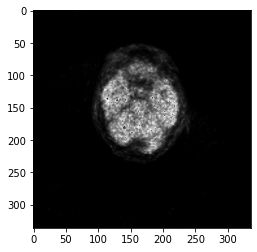

0


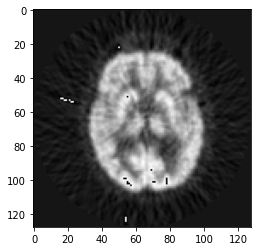

0


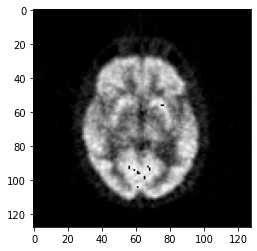

0


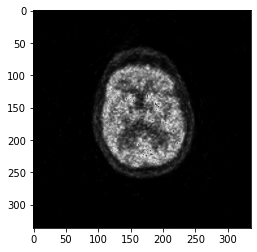

0


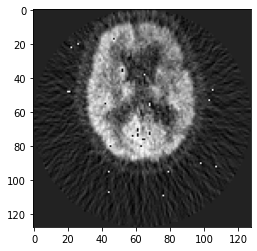

1


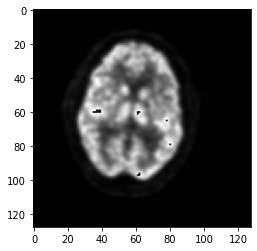

0


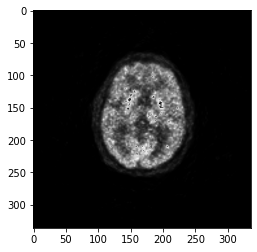

0


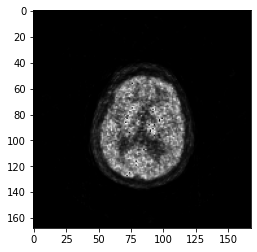

0


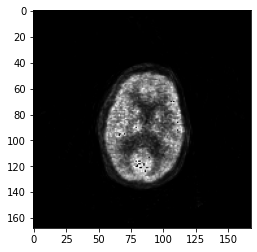

1


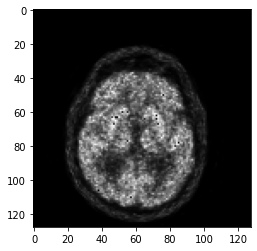

1


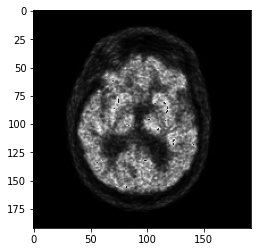

1


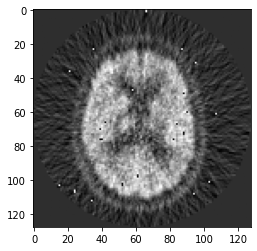

1


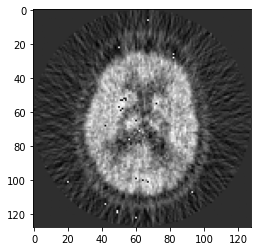

1


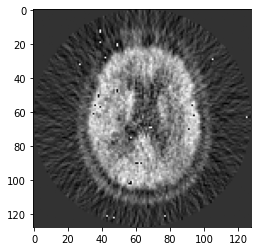

1


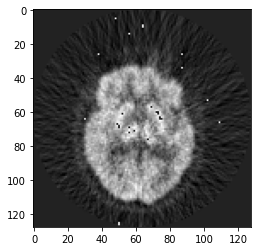

1


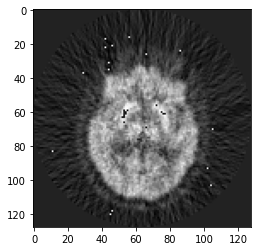

1


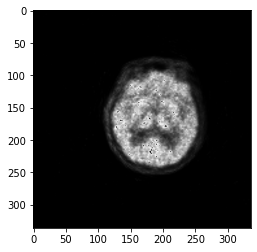

0


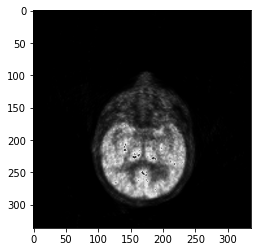

0


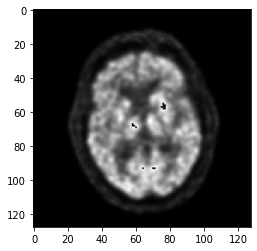

0


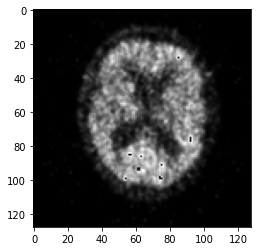

1


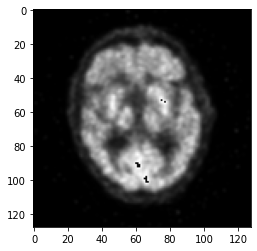

1


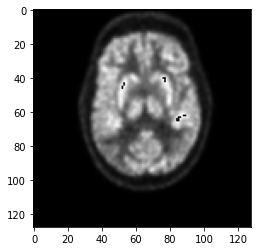

1


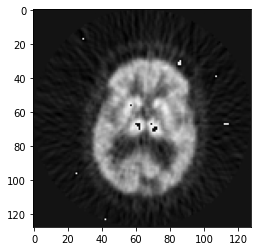

1


KeyboardInterrupt: ignored

<Figure size 432x288 with 0 Axes>

In [ ]:
X_val = np.load('/content/drive/MyDrive/Data_Shortcut/Module1_ADNI/Numpy_files/FDGPET_val_images.npy', allow_pickle = True)
print(X_val.shape)
for i in range(len(X_val)):
  plt.imshow(X_val[i], cmap = 'jet')
  plt.show()
  print(Y_val[i])
  

There are 1250 images in training set
There are 230 images in validation set
There are 270 images in test set


Text(0.5, 1.0, 'CN')

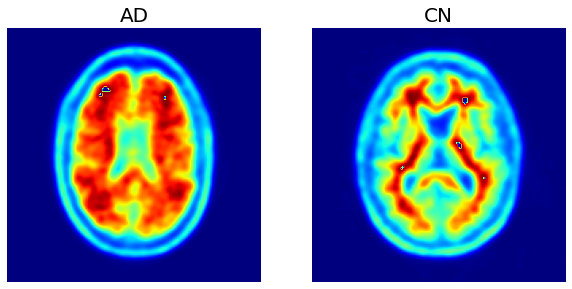

In [13]:
# Let's confirm the size of the training and validation arrays
print(f'There are {len(X_train)} images in training set')
print(f'There are {len(X_val)} images in validation set')
print(f'There are {len(X_test)} images in test set')


# Visualize the images (no AD patients images right now so both images are normal - To change)
plt.figure(figsize=(10,20))
plt.subplot(1,2,1)
plt.imshow(X_train[1][:,:,0], cmap = 'jet')
plt.axis('off')
plt.title('AD', fontsize=20)
plt.subplot(1,2,2)
plt.imshow(X_train[6][:,:,0], cmap = 'jet')
plt.axis('off')
plt.title('CN', fontsize=20)


In [ ]:
# Let's look at the PET images of CN and AD patients
plt.figure(figsize = (20, 100))
for i in range(100):
    
    plt.subplot(20,5, i+1) 
    plt.imshow(X_train[i][:,:,0], cmap = 'jet')
    plt.axis('off')
    plt.title(Y_train[i])
  

In [ ]:
X_train = np.asarray([resize(X_train[i], (160, 160)) for i in range(len(X_train))])
X_val = np.asarray([resize(X_val[i], (160, 160)) for i in range(len(X_val))])
X_test = np.asarray([resize(X_test[i], (160, 160)) for i in range(len(X_test))])

In [14]:
# Let's create the train, validation and test datasets
dataset_train = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
dataset_val = tf.data.Dataset.from_tensor_slices((X_val, Y_val))
dataset_test = tf.data.Dataset.from_tensor_slices((X_test, Y_test))


In [15]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 100

train_dataset = dataset_train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = dataset_val.batch(BATCH_SIZE)
test_dataset = dataset_test.batch(BATCH_SIZE)

In [ ]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)


Found 2000 files belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [ ]:
val_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [ ]:
val_batches = tf.data.experimental.cardinality(val_dataset)
test_dataset = val_dataset.take(val_batches // 5)
val_dataset = val_dataset.skip(val_batches // 5)


In [16]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 8
Number of test batches: 9


In [17]:
# Configure the data for performance
# Use buffered prefetching to load images from disk without having I/O become blocking.
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Step 4: Let's look at image augmentation now.

Augmentation is a technique to increase the diversity of your training set by applying random (but realistic) transformations, such as image rotation. This helps expose the model to different aspects of the training data and reduce overfitting.

Note: Augmentation should be applied only on the training set.

(160, 160, 3)


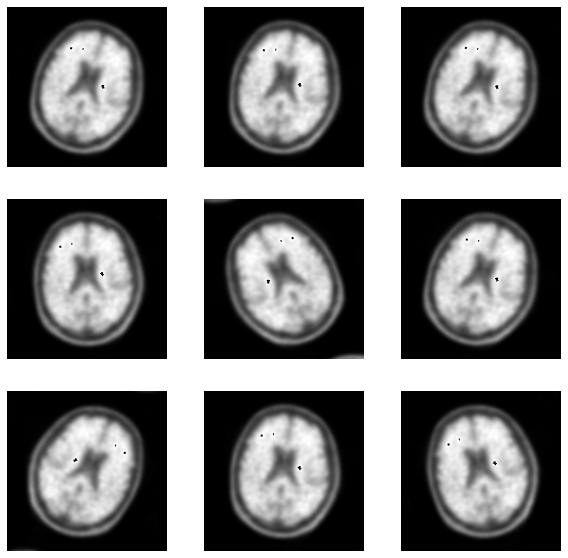

In [18]:
# Let's look at examples of image augmentation now

# We will create a few pre-processing layers and apply it to the PET image to understand how augmentation works

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
])

for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]

  print(first_image.shape)
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image,0))
    plt.imshow(augmented_image[0], cmap = 'jet')
    plt.axis('off')


## Step 5: Let's build our model now. For the first run, we will use MobileNetV2 pre-trained network.This model expects pixel values in [-1, 1].

A pre-trained network has already learnt to extract powerful and informative features from natural images and we will use it as a starting point to learn a new task.MobileNetV2 is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like jackfruit and syringe. This base of knowledge will help  classify CN and AD from this dataset.

First, we will need to pick which layer of MobileNet V2 we will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, we will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, we will instantiate a MobileNetV2 model pre-loaded with weights trained on ImageNet. By specifying the include_top=False argument, we load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [19]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SIZE = (160, 160)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [20]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 79, 79, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 79, 79, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

This feature extractor converts each 160x160x3 image into a 5x5x1280 block of features. Let's see what it does to an example batch of images.

In [21]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 3, 3, 2048)


## Step 6: Feature extraction


In this step, we will freeze the convolutional base created from the previous step and use as a feature extractor. Additionally, we will add a classifier on top of it and train the top-level classifier.

It is important to freeze the convolutional base before we compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. 


In [22]:
# MobileNetV2 has many layers, so setting the entire model's trainable flag to False will freeze all of them.
base_model.trainable = False


Many models contain tf.keras.layers.BatchNormalization layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this notebook.

When we set layer.trainable = False, the BatchNormalization layer will run in inference mode, and will not update its mean and variance statistics.

When we unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, we should keep the BatchNormalization layers in inference mode by passing training = False when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

In [23]:
# Add a classification head. 

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)



(32, 2048)


We will now apply a tf.keras.layers.Dense layer to convert these features into a single prediction per image.
We don't need an activation function here because this prediction will be treated as a logit, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [24]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Now let's build a model by using everything we have learnt so far -  the data augmentation, base_model and feature extractor layers using the Keras Functional API. As previously mentioned, use training=False as our model contains a BatchNormalization layer.

In [25]:
#preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
#x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

Let's compile the model before training it. Since there are two classes, we will use the tf.keras.losses.BinaryCrossentropy loss with from_logits=True since the model provides a linear output.

In [26]:
# Compile the model

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
# Let's look at the model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                             

The 2.5M parameters in MobileNetV2 are frozen, but there are 1.2K trainable parameters in the Dense layer. These are divided between two tf.Variable objects, the weights and biases.

In [28]:
len(model.trainable_variables)

2

Let's do the model training now! We will train for 10 epochs.

In [29]:
# Train the model

initial_epochs = 5

loss0, accuracy0 = model.evaluate(val_dataset)

8/8 [==============================] - 2s 196ms/step - loss: 0.8178 - accuracy: 0.5348


In [30]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.82
initial accuracy: 0.53


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=val_dataset)

Epoch 1/5
40/40 [==============================] - 17s 410ms/step - loss: 1.0083 - accuracy: 0.5568 - val_loss: 0.6750 - val_accuracy: 0.6304
Epoch 2/5
40/40 [==============================] - 16s 397ms/step - loss: 0.9552 - accuracy: 0.5744 - val_loss: 0.6373 - val_accuracy: 0.6739


## Step 7: Now let's take a look at the learning curve.

Learning curves are a widely used diagnostic tool in machine learning for algorithms that learn from a training dataset incrementally. The model can be evaluated on the training dataset and on a hold out validation dataset after each update during training and plots of the measured performance can created to show learning curves.

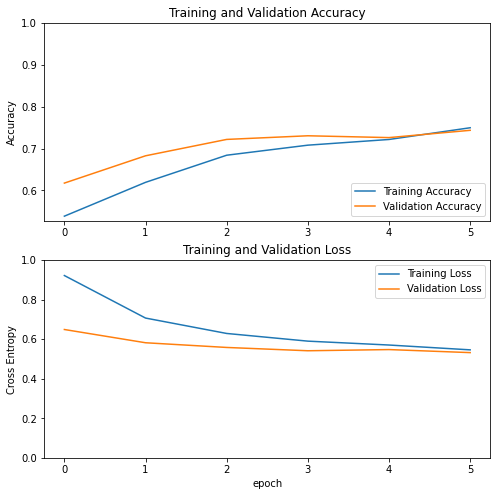

In [37]:
# Learning curves

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Step 8: Fine-tuning

In the feature extraction experiment, were were only training a few layers on top of an MobileNetV2 base model. The weights of the pre-trained network were not updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier we added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Also, it's good to note that we should try to fine-tune a small number of top layers rather than the whole MobileNetV2 model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

In [38]:
# Un-freeze the top layers of the model
base_model.trainable = True

In [39]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  311


Now let's compile the model. As we are training a much larger model and want to readapt the pre-trained weights, it is important to use a lower learning rate at this stage. Otherwise, our model could overfit very quickly.

In [40]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(lr=base_learning_rate/5),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [41]:
# Let's take a look at the model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                             

In [42]:
# Let's look at the number of trainable variables now.
len(model.trainable_variables)

130

Let's continue to train the model. If we were able to train the model to convergence earlier, this step will further improve the accuracy.

In [43]:
fine_tune_epochs = 30
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_dataset)

Epoch 6/36
40/40 [==============================] - 17s 409ms/step - loss: 0.4701 - accuracy: 0.7976 - val_loss: 0.4684 - val_accuracy: 0.8000
Epoch 7/36
40/40 [==============================] - 16s 402ms/step - loss: 0.3211 - accuracy: 0.8648 - val_loss: 0.4475 - val_accuracy: 0.8435
Epoch 8/36
40/40 [==============================] - 16s 404ms/step - loss: 0.2464 - accuracy: 0.8984 - val_loss: 0.6407 - val_accuracy: 0.8304
Epoch 9/36
40/40 [==============================] - 16s 401ms/step - loss: 0.1864 - accuracy: 0.9256 - val_loss: 0.6093 - val_accuracy: 0.8174
Epoch 10/36
40/40 [==============================] - 16s 401ms/step - loss: 0.1384 - accuracy: 0.9408 - val_loss: 0.5939 - val_accuracy: 0.8348
Epoch 11/36
40/40 [==============================] - 16s 402ms/step - loss: 0.1085 - accuracy: 0.9568 - val_loss: 0.7774 - val_accuracy: 0.8043
Epoch 12/36
40/40 [==============================] - 16s 402ms/step - loss: 0.0975 - accuracy: 0.9568 - val_loss: 0.6226 - val_accuracy: 0.8

## Step 9: Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNetV2 base model and training the classifier on top of it. 


In [44]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

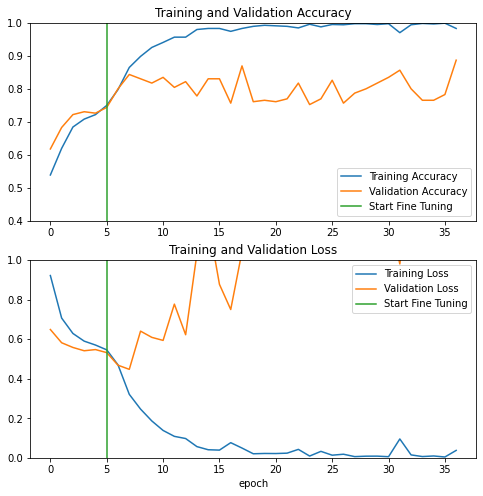

In [45]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.4, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Step 10: Evaluate the model.

We can now verify the performance of the model on new data using test set.

In [46]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

9/9 [==============================] - 2s 209ms/step - loss: 1.3375 - accuracy: 0.8037
Test accuracy : 0.8037037253379822


Step 11: What next? Time to play!
As a home-work or self learning task, you can try a variety of experiments to understand how the model performance is affected.

You can also do some of this as your term project.

Try to think about what could improve the model performance?

1. Will increasing the size of training set help? We are just using 1 slice per volume, will using more slices help?
2. Will changing the hyper-parameters like optimizer, learning rate, loss function, epochs, batch size improve the model performance? For ex. What will happen if you change the optimizer to Adam?
3. Will changing the model achitecture help? Check tf.keras.applications for different model architectures like - VGG16, VGG19, InceptionV3, ResNet50, etc.
4. How is the learning curve for this trained model? Is it underfitting? Does it need more training? How much training is enough and when should I stop?

And there is so much more! This is just a starting point. Model training and hyper-parameter tuning is the fun part of any deep learning project.

Next what? In this example we learnt a binary or 2 class classification problem. It can be extended to a multi-class problem.

Another fun task to do would be to try a multi-class classification where you can try and predict the different groups like CN, AD, LMCI, etc. What will you need to modify in the current code to change it to a multi-class problem?

